In [15]:
import torch

# 定义一个句子列表
sentences = [
    "Kage is Teacher",
    "Mazaong is Boss",
    "Niuzong is Boss",
    "Xiaobing is Student",
    "Xiaoxue is Student",
]
# 将所有的句子连接在一起，然后使用空格分割多个单词
words = " ".join(sentences).split()
# 构建词汇表，使用set去重
word_list = list(set(words))
# 创建一个字典，将每个词映射到唯一的索引
word_to_idx = {word: i for i, word in enumerate(word_list)}
# 创建一个字典，将每个索引映射到唯一的词
idx_to_word = {i: word for i, word in enumerate(word_list)}
voc_size = len(word_list)  # 词汇表大小
print("词汇表：", word_list)
print("词汇到索引的字典：", word_to_idx)
print("索引到词汇的字典：", idx_to_word)
print("词汇表大小：", voc_size)

词汇表： ['Xiaobing', 'Kage', 'Student', 'Niuzong', 'Teacher', 'Boss', 'Mazaong', 'Xiaoxue', 'is']
词汇到索引的字典： {'Xiaobing': 0, 'Kage': 1, 'Student': 2, 'Niuzong': 3, 'Teacher': 4, 'Boss': 5, 'Mazaong': 6, 'Xiaoxue': 7, 'is': 8}
索引到词汇的字典： {0: 'Xiaobing', 1: 'Kage', 2: 'Student', 3: 'Niuzong', 4: 'Teacher', 5: 'Boss', 6: 'Mazaong', 7: 'Xiaoxue', 8: 'is'}
词汇表大小： 9


In [16]:
# 生成Skip-Gram训练数据
def create_skipgram_dataset(sentences, window_size=2):
    data = []
    for sentence in sentences:  # 遍历每个句子
        sentence = sentence.split()  # 将句子分割成单词
        for idx, word in enumerate(sentence):  # 遍历单词及其索引
            # 获取相邻单词，将当前的单词和后N个单词组成一个元组
            for neighbor in sentence[max(idx - window_size, 0): min(idx + window_size + 1, len(sentence))]:
                if neighbor != word:  # 排除当前的单词本身
                    data.append((neighbor, word))  # 将相邻单词和当前单词组成一个元组
    return data
# 使用函数创建Skip-Gram训练数据
skipgram_data = create_skipgram_dataset(sentences)
# 打印Skip-Gram训练数据（前三个）
print("Skip-Gram训练数据：", skipgram_data[:3])

Skip-Gram训练数据： [('is', 'Kage'), ('Teacher', 'Kage'), ('Kage', 'is')]


In [17]:
# 定义Skip-Gram类
import torch.nn as nn
class SkipGram(nn.Module):
    def __init__(self, voc_size, emb_size):
        super(SkipGram, self).__init__()
        # 从词汇表大小到嵌入层大小（维度）的线性层（权重矩阵）
        self.input_to_hidden = nn.Embedding(voc_size, emb_size)
        # 从嵌入层大小（维度）到词汇表大小的线性层（权重矩阵）
        self.hidden_to_output = nn.Linear(emb_size, voc_size, bias=False)
    def forward(self, X):
        # 通过隐藏层，hidden形状为[batch_size, emb_size]
        hidden = self.input_to_hidden(X)
        # 通过输出层，output形状为[batch_size, voc_size]
        output = self.hidden_to_output(hidden)
        return output
    
embedding_size = 2  # 嵌入层大小（维度）
skipgram_model = SkipGram(voc_size, embedding_size)
print("Skip-Gram模型：", skipgram_model)

Skip-Gram模型： SkipGram(
  (input_to_hidden): Embedding(9, 2)
  (hidden_to_output): Linear(in_features=2, out_features=9, bias=False)
)


Epoch: 100, Loss: 2.095111068089803
Epoch: 200, Loss: 2.0206836064656577
Epoch: 300, Loss: 1.9701861103375753
Epoch: 400, Loss: 1.9321691294511159
Epoch: 500, Loss: 1.901148804028829
Epoch: 600, Loss: 1.8740347305933633
Epoch: 700, Loss: 1.8491009652614594
Epoch: 800, Loss: 1.8255384067694347
Epoch: 900, Loss: 1.803135299682617
Epoch: 1000, Loss: 1.7819815556208292


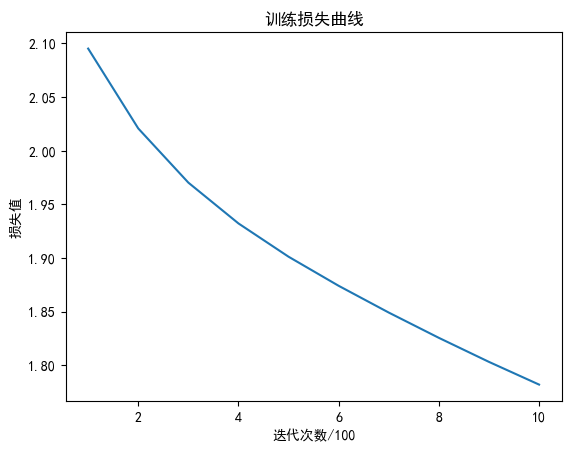

In [18]:
# 训练
learning_rate = 0.001  # 学习率
epochs = 1000  # 迭代次数
criterion = nn.CrossEntropyLoss()  # 损失函数
import torch.optim as optim # 优化器
optimizer = optim.SGD(skipgram_model.parameters(), lr=learning_rate)  # 随机梯度下降优化器
# 开始训练
loss_values = []  # 保存损失值
for epoch in range(epochs):
    loss_sum = 0
    for context, target in skipgram_data:
        X = torch.tensor([word_to_idx[target]], dtype=torch.long)  # 输入
        y_true = torch.tensor([word_to_idx[context]], dtype=torch.long)
        y_pred = skipgram_model(X)  # 前向传播
        loss = criterion(y_pred, y_true) # 计算损失
        loss_sum += loss.item() # 累加损失
        optimizer.zero_grad() # 梯度清零
        loss.backward()  # 反向传播
        optimizer.step() # 更新参数
    if (epoch + 1) % 100 == 0:
        print(f"Epoch: {epoch + 1}, Loss: {loss_sum/len(skipgram_data)}")
        loss_values.append(loss_sum / len(skipgram_data))
# 绘制损失曲线
import matplotlib.pyplot as plt
# 绘制二维向量图
plt.rcParams['font.family']='sans-serif'
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False # 显示负号
plt.plot(range(1, epochs // 100 + 1), loss_values)
plt.title("训练损失曲线")
plt.xlabel("迭代次数/100")
plt.ylabel("损失值")
plt.show()